In [6]:
#import random
import torch as tc
import numpy as np
import qutip as qt
import function as my
import matplotlib.pyplot as plt

from tqdm import tqdm

In [7]:
def data_qubit_two_crosstalk(lista_J,dissipation,tfinal,N,O_op,device="cpu"):
    # Operadores de Pauli para cada qubit
    XX,XY,XZ = qt.tensor(qt.sigmax(),qt.sigmax()),qt.tensor(qt.sigmax(),qt.sigmay()),qt.tensor(qt.sigmax(),qt.sigmaz())
    YX,YY,YZ = qt.tensor(qt.sigmay(),qt.sigmax()),qt.tensor(qt.sigmay(),qt.sigmay()),qt.tensor(qt.sigmay(),qt.sigmaz())
    ZX,ZY,ZZ = qt.tensor(qt.sigmaz(),qt.sigmax()),qt.tensor(qt.sigmaz(),qt.sigmay()),qt.tensor(qt.sigmaz(),qt.sigmaz())
    operadores = [XX,XY,XZ,
                  YX,YY,YZ,
                  ZX,ZY,ZZ]
    
    H = 0
    for i in range(len(lista_J)):
        H += 0.5*lista_J[i]*operadores[i]

    # Hamiltonian Lindbladian
    c_ops = [np.sqrt(dissipation[0])*qt.tensor(qt.sigmam(), qt.qeye(2)),
             np.sqrt(dissipation[1])*qt.tensor(qt.sigmaz(), qt.qeye(2)),
             np.sqrt(dissipation[2])*qt.tensor(qt.qeye(2) , qt.sigmam()),
             np.sqrt(dissipation[3])*qt.tensor(qt.qeye(2) , qt.sigmaz()),]
    # Estado inicial (cada qubit na superposição de |0> e |1>)
    # |+> = (|0> + |1>)/sqrt(2)
    theta1  = np.pi/4
    phi1    = 0.0 #np.pi/3
    ket_plus1 = (np.cos(theta1)*qt.basis(2, 0)+np.sin(theta1)*np.exp(1j*phi1)*qt.basis(2, 1))
    theta2  = np.pi/4
    phi2    = 0.0 #np.pi/5
    ket_plus2 = (np.cos(theta2)*qt.basis(2, 0)+np.sin(theta2)*np.exp(1j*phi2)*qt.basis(2, 1))

    psi0 = qt.tensor(ket_plus1, ket_plus2)
    
    # Lista de tempos para a evolução
    tlist = np.linspace(0.0, tfinal, N)

    # Solução da equação de Schrödinger
    options = qt.Options(nsteps = 100000, atol = 1e-14, rtol = 1e-14)
    result  = qt.mesolve(H, psi0, tlist, c_ops=c_ops, e_ops=O_op,options=options)

    expect  = tc.tensor( np.array( result.expect),device = device).transpose(0, 1)
    return expect

O_op =[ qt.tensor(qt.qeye(2) , qt.sigmax()),
        qt.tensor(qt.qeye(2) , qt.sigmay()),
        qt.tensor(qt.qeye(2) , qt.sigmaz()),
        qt.tensor(qt.sigmax(), qt.qeye(2) ),
        qt.tensor(qt.sigmax(), qt.sigmax()),
        qt.tensor(qt.sigmax(), qt.sigmay()),
        qt.tensor(qt.sigmax(), qt.sigmaz()),
        qt.tensor(qt.sigmay(), qt.qeye(2) ),
        qt.tensor(qt.sigmay(), qt.sigmax()),
        qt.tensor(qt.sigmay(), qt.sigmay()),
        qt.tensor(qt.sigmay(), qt.sigmaz()),
        qt.tensor(qt.sigmaz(), qt.qeye(2) ),
        qt.tensor(qt.sigmaz(), qt.sigmax()),
        qt.tensor(qt.sigmaz(), qt.sigmay()),
        qt.tensor(qt.sigmaz(), qt.sigmaz()),
        ]


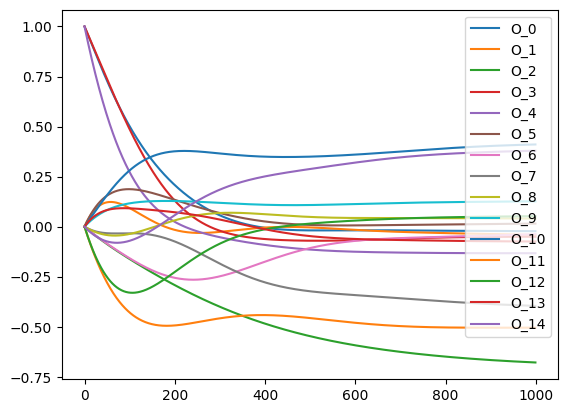

[ 0.58273221  0.04225183  0.80358457  0.28892294  0.39623089  0.75233437
 -0.21712124 -0.37412713  0.89985466] [0.84807472 0.20688445 0.27085535 0.36992041]


In [8]:
Js          = np.random.uniform(-1,1,9)
dissipation = np.random.rand(4)

tfinal      = 2*np.pi
N           = 1000

valor_esperado_data  = data_qubit_two_crosstalk(Js,dissipation,tfinal,N,O_op,device="cpu")

for i in range(len(O_op)):
    plt.plot(valor_esperado_data[:,i].cpu() ,label=f"O_{i}")

plt.legend()
plt.show()
print(Js,dissipation)

In [9]:
neuronio = [50,50]
X_vector   = my.Rede(
    neuronio    = neuronio,
    input_      = 1,
    output_     = len(O_op),
    activation  =[tc.nn.Tanh()]*len(neuronio),
    creat_p     =True,
    N_of_paramater= 9 +4)
opt = tc.optim.Adam(X_vector.parameters(),
        lr = 0.001 )
time =  tc.linspace(
        0,
        tfinal,
        N,
        dtype   = tc.float32,
        requires_grad = True).reshape((-1, 1))
index_data = np.random.randint(0,N,size=20)
X_vector.parametro

Parameter containing:
tensor([0.7631, 0.4420, 0.1019, 0.8972, 0.8872, 0.4653, 0.8914, 0.0016, 0.9063,
        0.6791, 0.6944, 0.3347, 0.4965], requires_grad=True)

In [10]:
epocas  = 2000
LOSS    = []
LOSS1   = []
LOSS2   = []
hisorty_of_param = []
for _ in tqdm(range(epocas)):
    ####### Forward pass #######
    y  = X_vector(time)     
    
    ######## Los edo #######
    dX_dt = []
    for i in range(y.shape[1]):
        dX_dt.append(tc.autograd.grad(outputs = y[:, i], 
                                    inputs = time,
                                    grad_outputs = tc.ones_like(y[:, i]),
                                    #retain_graph = True,
                                    create_graph = True)[0])
    dX_dt   = tc.cat(dX_dt, dim=1)
    
    IX,IY,IZ,XI,XX,XY,XZ = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4],y[:, 4:5], y[:, 5:6],y[:, 6:7]
    YI,YX,YY,YZ,ZI,ZX,ZY,ZZ = y[:, 7:8], y[:, 8:9], y[:, 9:10],y[:, 10:11], y[:, 11:12], y[:,12:13], y[:,13:14], y[:,14:15]

    JXX,JXY,JXZ,JYX,JYY,JYZ,JZX,JZY,JZZ,gamma1,gamma2,gamma3,gamma4 = X_vector.parametro
    
    LOSS_edo  = 0
    LOSS_edo += (dX_dt[:,0:1] - ( +IX*(-0.5*gamma3 - 2.0*gamma4) +(-1.0*JXZ)*XY +JXY*XZ +(-1.0*JYZ)*YY +(1.0*JYY)*YZ +(-1.0*JZZ)*ZY +(1.0*JZY)*ZZ))**2
    LOSS_edo += (dX_dt[:,1:2] - ( +IY*(-0.5*gamma3 - 2.0*gamma4) +(1.0*JXZ)*XX +(-1.0*JXX)*XZ +JYZ*YX +(-1.0*JYX)*YZ +(1.0*JZZ)*ZX +(-JZX)*ZZ))**2
    LOSS_edo += (dX_dt[:,2:3] - ( (-1.0*gamma3) +IZ*(-1.0*gamma3) +(-1.0*JXY)*XX +(1.0*JXX)*XY +(-1.0*JYY)*YX +JYX*YY +(-1.0*JZY)*ZX +(1.0*JZX)*ZY))**2
    LOSS_edo += (dX_dt[:,3:4] - ( +XI*(-0.5*gamma1 - 2.0*gamma2) +(-1.0*JZX)*YX +(-1.0*JZY)*YY +(-1.0*JZZ)*YZ +JYX*ZX +(1.0*JYY)*ZY +(1.0*JYZ)*ZZ))**2
    LOSS_edo += (dX_dt[:,4:5] - ( +IY*(-1.0*JXZ) +IZ*(1.0*JXY) +XX*(-0.5*gamma1 - 2.0*gamma2 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JZX)*YI +(1.0*JYX)*ZI))**2
    LOSS_edo += (dX_dt[:,5:6] - ( +IX*JXZ +IZ*(-1.0*JXX) +XY*(-0.5*gamma1 - 2.0*gamma2 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JZY)*YI +(1.0*JYY)*ZI))**2
    LOSS_edo += (dX_dt[:,6:7] - ( +IX*(-1.0*JXY) +IY*(1.0*JXX) +XI*(-1.0*gamma3) +XZ*(-0.5*gamma1 - 2.0*gamma2 - 1.0*gamma3) +(-1.0*JZZ)*YI +(1.0*JYZ)*ZI))**2
    LOSS_edo += (dX_dt[:,7:8] - ( +(1.0*JZX)*XX +JZY*XY +(1.0*JZZ)*XZ +YI*(-0.5*gamma1 - 2.0*gamma2) +(-1.0*JXX)*ZX +(-1.0*JXY)*ZY +(-JXZ)*ZZ))**2
    LOSS_edo += (dX_dt[:,8:9] - ( +IY*(-1.0*JYZ) +IZ*(1.0*JYY) +JZX*XI +YX*(-0.5*gamma1 - 2.0*gamma2 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JXX)*ZI))**2
    LOSS_edo += (dX_dt[:,9:10] - ( +IX*(1.0*JYZ) +IZ*(-1.0*JYX) +(1.0*JZY)*XI +YY*(-0.5*gamma1 - 2.0*gamma2 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JXY)*ZI))**2
    LOSS_edo += (dX_dt[:,10:11] - ( +IX*(-1.0*JYY) +IY*JYX +(1.0*JZZ)*XI +YI*(-1.0*gamma3) +YZ*(-0.5*gamma1 - 2.0*gamma2 - 1.0*gamma3) +(-JXZ)*ZI))**2
    LOSS_edo += (dX_dt[:,11:12] - ( (-1.0*gamma1) +(-1.0*JYX)*XX +(-1.0*JYY)*XY +(-1.0*JYZ)*XZ +(1.0*JXX)*YX +JXY*YY +(1.0*JXZ)*YZ +ZI*(-1.0*gamma1)))**2
    LOSS_edo += (dX_dt[:,12:13] - ( +IX*(-1.0*gamma1) +IY*(-1.0*JZZ) +IZ*(1.0*JZY) +(-1.0*JYX)*XI +(1.0*JXX)*YI +ZX*(-1.0*gamma1 - 0.5*gamma3 - 2.0*gamma4)))**2
    LOSS_edo += (dX_dt[:,13:14] - ( +IX*(1.0*JZZ) +IY*(-1.0*gamma1) +IZ*(-JZX) +(-1.0*JYY)*XI +JXY*YI +ZY*(-1.0*gamma1 - 0.5*gamma3 - 2.0*gamma4)))**2
    LOSS_edo += (dX_dt[:,14:15] - ( +IX*(-1.0*JZY) +IY*(1.0*JZX) +IZ*(-1.0*gamma1) +(-1.0*JYZ)*XI +(1.0*JXZ)*YI +ZI*(-1.0*gamma3) +ZZ*(-1.0*gamma1 - 1.0*gamma3)))**2
    LOSS_edo = LOSS_edo.mean() 
    ####### loss data(expected values) #######
    LOSS_data = tc.mean((y[index_data,:]  - valor_esperado_data[index_data,:])**2) 
    
    ####### Loss total #######
    loss_i = LOSS_edo*0.01 + LOSS_data
    
    ####### Backpropagation #######
    opt.zero_grad()
    loss_i.backward()
    opt.step()
    LOSS1.append(LOSS_edo.cpu().detach().numpy())
    LOSS2.append(LOSS_data.cpu().detach().numpy())
    LOSS.append(loss_i.cpu().detach().numpy())

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [03:38<00:00,  9.17it/s]


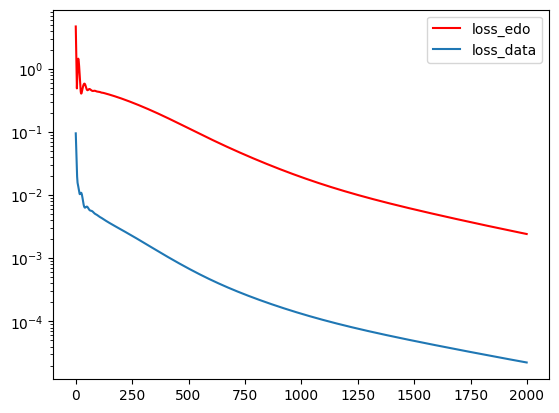

Valor final: Parameter containing:
tensor([ 0.5689,  0.1344,  0.6421,  0.2120,  0.3816,  0.6826, -0.0929, -0.3773,
         0.8547,  0.7173,  0.1695,  0.2539,  0.3686], requires_grad=True)


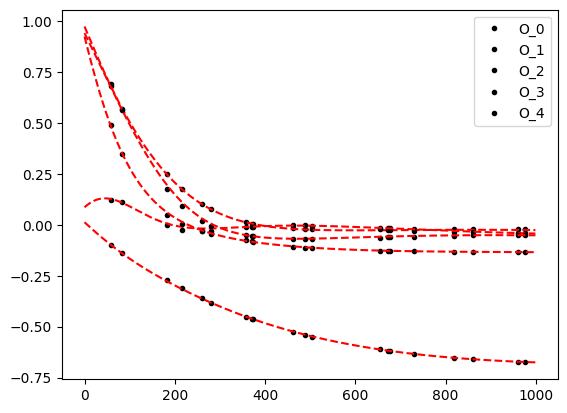

In [11]:
#plt.plot(LOSS,"k.",label="loss_total")
plt.plot(LOSS1,'r-',label="loss_edo")
plt.plot(LOSS2,label="loss_data")
plt.yscale("log")
plt.legend()
plt.show()
print("Valor final:",X_vector.parametro)


X_vector.eval()
X_  = X_vector(time).detach().numpy()

for i in range(5):
    plt.plot(index_data,valor_esperado_data[index_data,i].cpu(),"k." ,label=f"O_{i}")
    plt.plot(X_[:,i],"r--")

# plt.plot(X_[:,3],"--",label="sigmaI_Y")

plt.legend()
plt.show()

In [12]:
abs(X_vector.parametro - tc.tensor(Js.tolist() + dissipation.tolist()))

tensor([0.0138, 0.0921, 0.1615, 0.0770, 0.0146, 0.0697, 0.1243, 0.0032, 0.0451,
        0.1307, 0.0374, 0.0169, 0.0013], grad_fn=<AbsBackward0>)